# Tracking centroids of segmented cells

In [1]:
%pip install -q --upgrade -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
napari-travali2 0.0.0 requires napari[pyqt5]<0.6.0,>=0.5.5, but you have napari 0.6.2 which is incompatible.
napari-travali2 0.0.0 requires numpy<2.2, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## Importing packages

`laptrack.LapTrack` is the core object for tracking. 

We also import `regionprops_table` from `skimage` to calculate the centroids of the segmentation masks.

In [2]:
import napari
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.measure import regionprops_table

from laptrack import LapTrack
from laptrack import datasets
from laptrack.data_conversion import convert_split_merge_df_to_napari_graph

## Load images and showing in napari

First, we load images to the napari viewer.

In [3]:
viewer = napari.Viewer()
images, labels = datasets.cell_segmentation()

viewer.add_image(images)
labels_layer = viewer.add_labels(labels)

## Calculating label centroids by `regionprops_table`

We then calculate the centroids for each labeled region in each frame.

In [4]:
regionprops = []
for frame, label in enumerate(labels):
    df = pd.DataFrame(regionprops_table(label, properties=["label", "centroid"]))
    df["frame"] = frame
    regionprops.append(df)
regionprops_df = pd.concat(regionprops)

## Tracking centroids by LapTrack

 This is where we use `LapTrack`. We track the centroids of the segmented regions.

In [5]:
lt = LapTrack(cutoff=15**2, splitting_cutoff=30**2)
track_df, split_df, merge_df = lt.predict_dataframe(
    regionprops_df.copy(),
    coordinate_cols=["centroid-0", "centroid-1"],
    only_coordinate_cols=False,
)

In [6]:
track_df = track_df.reset_index()
graph = convert_split_merge_df_to_napari_graph(split_df, merge_df)
viewer.add_tracks(
    track_df[["track_id", "frame", "centroid-0", "centroid-1"]],
    graph=graph,
)

<Tracks layer 'Tracks' at 0x152a73d70>

## Showing clonal cells by the same colors

To check the result, we show the clonal cell regions by the same colors.

In [7]:
new_labels = np.zeros_like(labels)

for i, row in track_df.iterrows():
    frame = int(row["frame"])
    inds = labels[frame] == row["label"]
    new_labels[frame][inds] = int(row["tree_id"]) + 1
viewer.add_labels(new_labels)
labels_layer.visible = False

([], [])

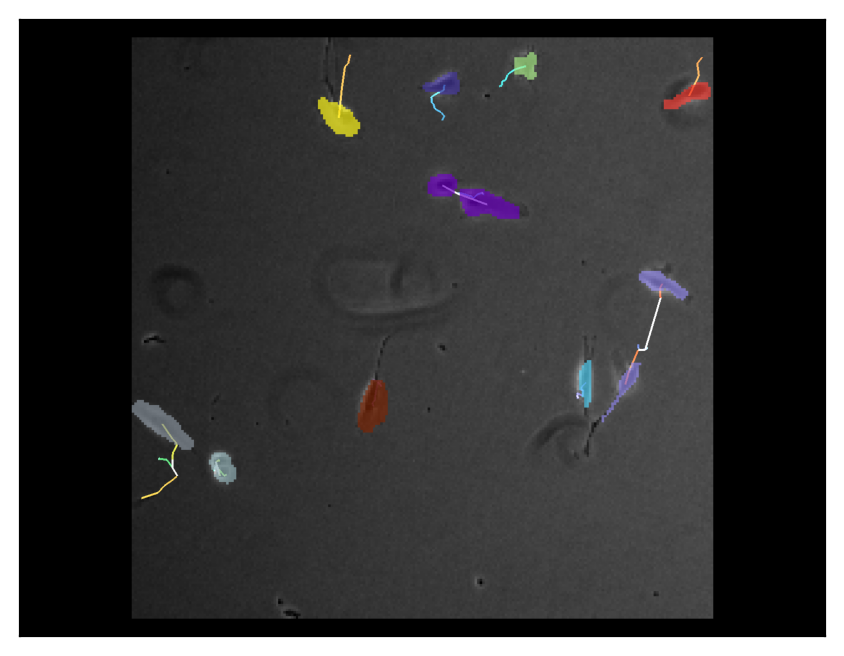

: 

In [ ]:
viewer.dims.current_step = (9, 0, 0)
plt.imshow(viewer.screenshot())
plt.xticks([])
plt.yticks([])